In [2]:
!git clone https://github.com/MinhHieu-Nguyen-dn/diabetes_active_proteins.git

Cloning into 'diabetes_active_proteins'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 10), reused 27 (delta 3), pack-reused 0
Receiving objects: 100% (35/35), 127.61 KiB | 1.00 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
uniprot_id = 'P15121'

# Get pre-processed data

In [4]:
import pandas as pd
import os
os.chdir('diabetes_active_proteins')
df = pd.read_csv('data/processed_P15121.csv', index_col=0)

In [5]:
df.head()

,molecule_chembl_id,IC50,units,smiles,fp,pIC50,active
0,CHEMBL18854,230.0,nM,CCCCCCS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.638272,1
1,CHEMBL19744,130.0,nM,CNS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.886057,1
2,CHEMBL19711,100.0,nM,O=C1NC(=O)C(c2cc(Cl)ccc2S(=O)(=O)NCCCc2ccccc2)N1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,7.000000,1
3,CHEMBL19392,5630.0,nM,O=C1NC(=O)C(c2cc(Cl)ccc2S(=O)(=O)NCCCCc2ccccc2)N1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,5.249492,0
4,CHEMBL19746,7470.0,nM,COc1ccc(F)cc1C1NC(=O)NC1=O,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,5.126679,0


## Prepare data for models

In [6]:
import numpy as np

In [7]:
def string_to_np_array(s: str):
  s = s.strip('[]')
  arr = np.fromstring(s, sep=' ')

  return arr

In [8]:
df['fp'] = df['fp'].apply(string_to_np_array)

In [9]:
from sklearn.model_selection import train_test_split


def df_to_data_split(df, random_seed=1):
  fingerprint_to_model = df.fp.tolist()
  label_to_model = df.active.tolist()

  (
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
  ) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=random_seed)

  splits = {
    'x_train': static_train_x,
    'x_test': static_test_x,
    'y_train': static_train_y,
    'y_test': static_test_y
  }

  return splits

In [10]:
data_splits = df_to_data_split(df=df)

# Models

PyTorch: Feed-forward Neural Network, CNN, LSTM  
ScikitLearn: GaussianNB, KNN, Random Forest, SVM  
XGBoost: XgBoost  

## Helper functions

In [11]:
from sklearn.metrics import auc, accuracy_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [24]:
def plot_roc_curves_for_models(models, test_x, test_y, uniprot_id):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    fig.savefig("{}_roc_auc".format(uniprot_id), dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits['x_train'], splits['x_test'], splits['y_train'], splits['y_test']

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

## Combinations of Machine Learning models - tuned with GridSearch  


*   GaussianNB
*   KNN
*   Random Forest
*   SVM
*   XGBoost





Training and tuning GaussianNB...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best parameters found by GridSearchCV:  {}
Sensitivity: 0.88
Specificity: 0.60
AUC: 0.81
Training and tuning KNN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[C

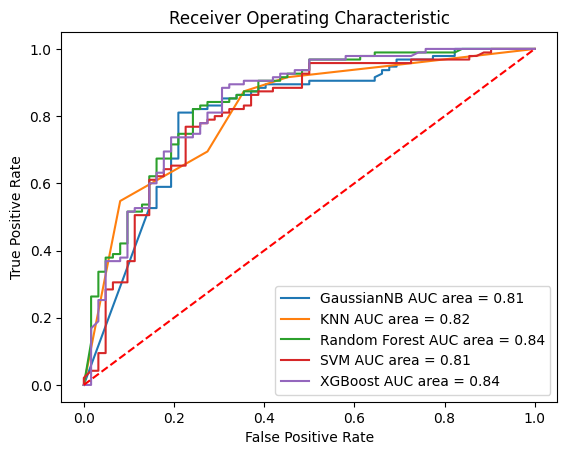

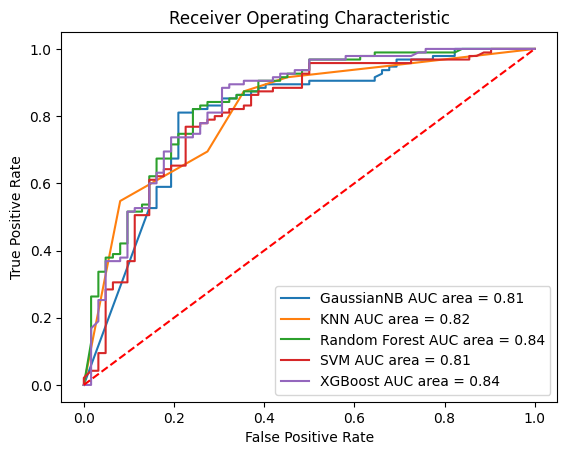

In [21]:
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the models and their respective hyperparameters
models = [
    {"model": GaussianNB(), "label": "GaussianNB", "params": {}},  # GaussianNB has no parameters to tune
    {"model": KNeighborsClassifier(), "label": "KNN", "params": {"n_neighbors": [3, 5, 7, 9]}},
    {"model": RandomForestClassifier(), "label": "Random Forest", "params": {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]}},
    {"model": svm.SVC(probability=True), "label": "SVM", "params": {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}},
    {"model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "label": "XGBoost", "params": {"n_estimators": [100, 200, 300], "max_depth": [3, 5, 7, 9], "learning_rate": [0.01, 0.1, 0.2, 0.3]}}
]

# Initialize the list that stores all models
models_tuned = []

# Train the models, tune hyperparameters, and print their performance
for model in models:
    print(f"Training and tuning {model['label']}...")

    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(model["model"], model["params"], refit=True, verbose=2)
    grid.fit(data_splits['x_train'], data_splits['y_train'])

    # Print the best parameters found by GridSearchCV
    print("Best parameters found by GridSearchCV: ", grid.best_params_)

    # Init a new model with the best parameters
    best_model = model["model"].set_params(**grid.best_params_)

    # Create 'model' directory if not exists
    if not os.path.exists('models'):
        os.makedirs('models')

    # Save the model
    save_path = os.path.join('models', '{}_{}_tuned.pt'.format(uniprot_id, model['label']))
    joblib.dump(best_model, save_path)

    # Fit model on single split
    performance_measures = model_training_and_validation(best_model, model["label"], data_splits)

    # Add the tuned model to the list
    models_tuned.append({"label": model["label"], "model": best_model})

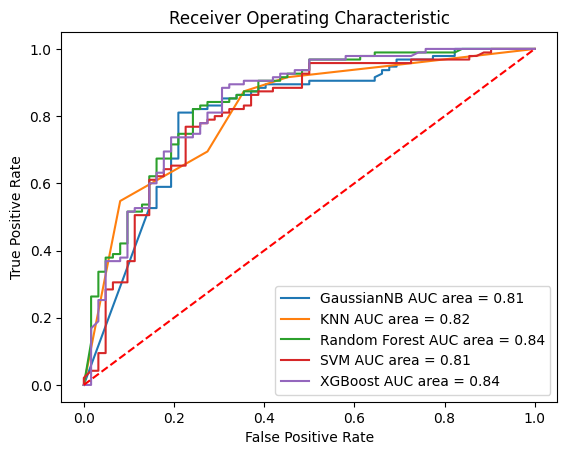

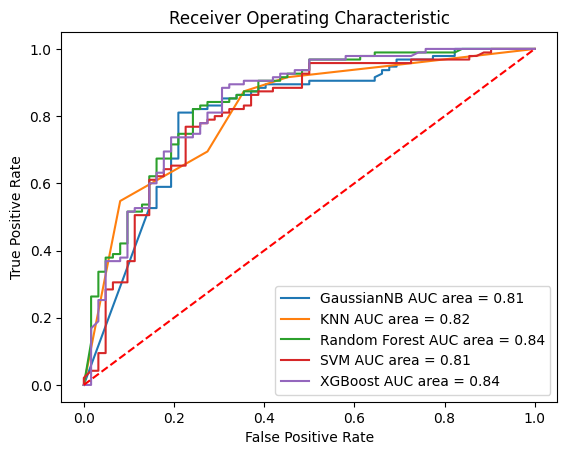

In [25]:
# Plot roc curve for the tuned models
plot_roc_curves_for_models(models_tuned, data_splits['x_test'], data_splits['y_test'], uniprot_id=uniprot_id)